<a href="https://colab.research.google.com/github/pintu1803/Fake_News_Detection_Hybrid_cnn-rnn/blob/main/fake_news_detection_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection:(Main)
##By Pintu and Akshay Dhayal


In [1]:
!unzip /content/drive/MyDrive/Project_Fake_News_Detection_DL/03_glove_files/glove.6B.100d.zip

Archive:  /content/drive/MyDrive/Project_Fake_News_Detection_DL/03_glove_files/glove.6B.100d.zip
  inflating: glove.6B.100d.txt       


In [2]:
!unzip /content/drive/MyDrive/Project_Fake_News_Detection_DL/03_glove_files/glove.6B.50d.zip

Archive:  /content/drive/MyDrive/Project_Fake_News_Detection_DL/03_glove_files/glove.6B.50d.zip
  inflating: glove.6B.50d.txt        


In [5]:

#Pintu, 181CO139
#date:23-04-2021

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers




#Function for training and validating of model.
def Training_Validating(filename, usable_vocab_size, maxlen_of_text, emb_dim, epochs, batch_size,
                        filename_xtest, filename_ytest, filename_history, filename_model):
    ###load dataset.
    filename=""+filename+".csv"
    dataset = pd.read_csv(filename)

    # remove the missing data.
    dataset = dataset.dropna()

    # split ratio= 8:2
    # 20% is used for validation.
    n = int(0.8 * len(dataset))

    # spliting 'text' and 'label' attributes,
    # for training and testing purposes.
    x = dataset['text'].values[:n]
    y = dataset['label'].values[:n]

    # for validation purpose.
    x_valid = dataset['text'].values[n:]
    y_valid = dataset['label'].values[n:]

    # dividing x,y for training and testing.
    # 20% of entire dataset is used for testing.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1000)

    # types of all splits is 'ndarray'
    # those ending with .values are ndarray.
    # train_test_split output has same type as of input.
    print("Type of dataset =>", type(dataset))
    print("Type of training & testing set=>", type(x))
    print("Type of validation set=>", type(x_valid))

    ###Creating vocabulary.
    tokenizer = Tokenizer(num_words=usable_vocab_size)
    tokenizer.fit_on_texts(x_train)

    # number of unique words in dict.
    print("Number of unique words in dictionary=", len(tokenizer.word_index))

    # replacing words by their index from vocabulary.
    x_train = tokenizer.texts_to_sequences(x_train)
    x_valid = tokenizer.texts_to_sequences(x_valid)
    x_test = tokenizer.texts_to_sequences(x_test)

    # Adding 1 because of  reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # size of random text in training set.
    print("Length of random text=>")
    print("Length of 4th text of train set=> ", len(x_train[3]))
    print("Length of 14th text of train set=> ", len(x_train[13]))

    # deciding the maximum length of text.
    maxlen = maxlen_of_text

    # padding the texts to maximum length.
    x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
    x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
    x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

    ###confirm that texts are converted in vector form.
    print("1st text of training set, upto 10 words =>\n", x_test[1][:10])

    ###Create embedding matrix.
    def create_embedding_matrix(filepath, word_index, embedding_dim):
        vocab_size = len(word_index) + 1
        # Adding again 1 because of reserved 0 index
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        # specify the encoding, o/w it may lead to error.
        with open(filepath, encoding='utf8') as f:
            for line in f:
                word, *vector = line.split()
                if word in word_index:
                    idx = word_index[word]
                    embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
        return embedding_matrix

    # set the size of dense_vector/feature_vector.
    # each word-> dense vector: length=emd_dim
    embedding_dim = emb_dim
    glove_file='/content/glove.6B.'+str(emb_dim)+'d.txt'
    embedding_matrix = create_embedding_matrix(glove_file, tokenizer.word_index, embedding_dim)

    ##Build the hybrid model.
    model = Sequential()
    model.add(
        layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    ##RUN the model, with epochs=10 & batch_size=64
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        validation_data=(x_valid, y_valid),
                        batch_size=batch_size)

    ###Save for 2nd part: testing.
    # save the x_test
    import pickle
    # Syntax of pickle.dump(object_to_dump, filepath)
    with open(filename_xtest, 'wb') as file_pi:
        pickle.dump(x_test, file_pi)

    # save the y_test
    with open(filename_ytest, 'wb') as file_path:
        pickle.dump(y_test, file_path)

    # save the history of the model.
    path = open(filename_history, 'wb')
    pickle.dump(history.history, path)
    path.close()

    # save the trained model.
    model.save(filename_model)

#############################################

def Testing(filename_xtest,filename_ytest,filename_history,filename_model):
    ###Load the saved files.
    # load the x_test.
    import pickle
    file_pi = open(filename_xtest, 'rb')
    x_test = pickle.load(file_pi)
    file_pi.close()

    # laod the y_test.
    file_path = open(filename_ytest, 'rb')
    y_test = pickle.load(file_path)
    file_path.close()

    # load the history
    path = open(filename_history, 'rb')
    history = pickle.load(path)
    path.close()

    # load the model
    from keras.models import load_model
    model = load_model(filename_model)

    # print summary of the model.
    model.summary()
    val_loss, val_acc = model.evaluate(x_test, y_test)

    # printing the evalution result.
    print("Validation accuracy=> %.2f" % (100 * val_acc), "%")
    print("Validation loss=> %.2f" % (100 * val_loss), "%")

    ##Prediction and performance
    def performance(x_test, y_test):
        y_pred = model.predict(x_test)
        # print(y_pred[0])
        y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
        # print(y_pred[0])
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        print("Confusion matrix=\n", cm)
        print("Classification report=\n", cr)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
        print("Testing Accuracy:  {:.4f}".format(100*accuracy),"%")  # actual accuracy
        print("Testing Loss: {:.4f}".format(100*loss),"%")  # testing loss

    # call the performance measure function
    performance(x_test, y_test)

    ##Print the loss and accuracy graph.
    import matplotlib.pyplot as plt
    def plot_history(history):
        #already passed the history.history.
        plt.plot(history['accuracy'], 'b', label='Training accuracy')
        plt.plot(history['val_accuracy'], 'g', label='Validation accuracy')
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history['loss'],'b', label='Training accuracy')
        plt.plot(history['val_loss'],'g', label='Validation accuracy')
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.show()

    # call the function using history
    plot_history(history)

############################################


#Execution - 1

Type of dataset => <class 'pandas.core.frame.DataFrame'>
Type of training & testing set=> <class 'numpy.ndarray'>
Type of validation set=> <class 'numpy.ndarray'>
Number of unique words in dictionary= 159687
Length of random text=>
Length of 4th text of train set=>  426
Length of 14th text of train set=>  25
1st text of training set, upto 10 words =>
 [ 132    4    1 1320  441 5418   11  247   15   28]
Epoch 1/10
172/172 [==============================] - 52s 289ms/step - loss: 0.5650 - accuracy: 0.7042 - val_loss: 0.3700 - val_accuracy: 0.8512
Epoch 2/10
172/172 [==============================] - 49s 285ms/step - loss: 0.3310 - accuracy: 0.8578 - val_loss: 0.2607 - val_accuracy: 0.8988
Epoch 3/10
172/172 [==============================] - 49s 284ms/step - loss: 0.1999 - accuracy: 0.9250 - val_loss: 0.2362 - val_accuracy: 0.9152
Epoch 4/10
172/172 [==============================] - 49s 286ms/step - loss: 0.1411 - accuracy: 0.9536 - val_loss: 0.2135 - val_accuracy: 0.9188
Epoch 5/10
172

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           7984400   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          32128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,037,169
Trainable params: 8,037,169
Non-trainable params: 0
_________________________________________________________________
115/115 [==============================] - 5s 35ms/step - loss: 0.2116 - accuracy: 0.9382
Validation accuracy=> 

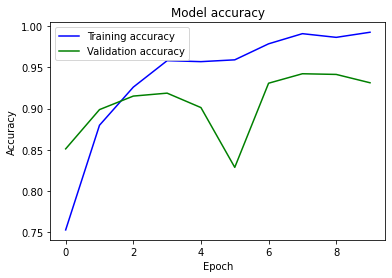

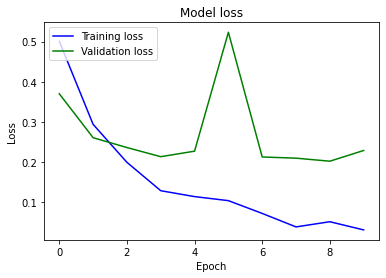

In [6]:

#Execution-1

# main function.
def main():
    # filename = input("Enter dataset name => ")
    # usable_vocab_size = int(input("Enter size of vocabulary to be used => "))#100000 to 150000
    # maxlen_of_text = int(input("Enter maximum length(size) of the text => "))#300 to 500
    # emb_dim = int(input("Enter length(size) of dense/feature vector =>"))#50 or 100
    # epochs = int(input("Enter number of epochs => "))  # 2 to 10
    # batch_size = int(input("Enter batchsize =>"))#32 to 128
    # filename_xtest = input("Enter filename for x_test (to pickle) =>")#xtest1 to xtestN
    # filename_ytest = input("Enter filename for y_test (to pickle) =>")
    # filename_history = input("Enter filename for history (to pickle) =>")
    # filename_model = input("Enter filename for model (to save) =>")
    # Training_Validating(filename, usable_vocab_size, maxlen_of_text, emb_dim, batch_size,
    #                     filename_xtest, filename_ytest, filename_history, filename_model)
    # Testing(filename_xtest, filename_ytest, filename_history, filename_model)

    Training_Validating('/content/drive/MyDrive/Project_Fake_News_Detection_DL/05_dataset/fake_news_dataset',100000,300,50,10,64,'x_test_1','y_test_1','history_1','model_1')
    Testing('x_test_1','y_test_1','history_1','model_1')
#############################################

# utility function of main.
if __name__ == '__main__':
    main()

#Execution - 2

Type of dataset => <class 'pandas.core.frame.DataFrame'>
Type of training & testing set=> <class 'numpy.ndarray'>
Type of validation set=> <class 'numpy.ndarray'>
Number of unique words in dictionary= 159687
Length of random text=>
Length of 4th text of train set=>  426
Length of 14th text of train set=>  25
1st text of training set, upto 10 words =>
 [1860   26    1  954  191  100    5  368 2251   67]
Epoch 1/10
172/172 [==============================] - 90s 511ms/step - loss: 0.5593 - accuracy: 0.7000 - val_loss: 0.3407 - val_accuracy: 0.8551
Epoch 2/10
172/172 [==============================] - 86s 499ms/step - loss: 0.3705 - accuracy: 0.8462 - val_loss: 0.2964 - val_accuracy: 0.8808
Epoch 3/10
172/172 [==============================] - 86s 497ms/step - loss: 0.2329 - accuracy: 0.9133 - val_loss: 0.3004 - val_accuracy: 0.8682
Epoch 4/10
172/172 [==============================] - 86s 498ms/step - loss: 0.1886 - accuracy: 0.9275 - val_loss: 0.2446 - val_accuracy: 0.8986
Epoch 5/10
172

INFO:tensorflow:Assets written to: model_2/assets


INFO:tensorflow:Assets written to: model_2/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 100)          15968800  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 346, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 173, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 16,053,569
Trainable params: 16,053,569
Non-trainable params: 0
_________________________________________________________________
115/115 [==============================] - 6s 46ms/step - loss: 0.1752 - accuracy: 0.9448
Validation accurac

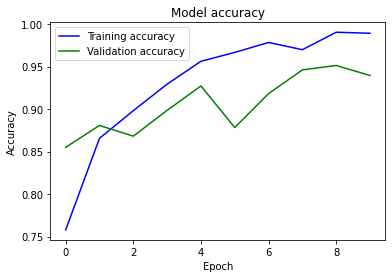

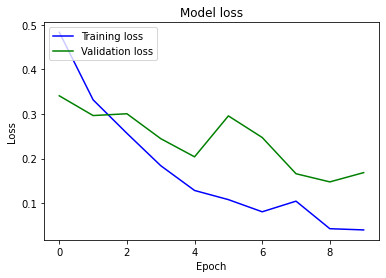

In [8]:

#Execution-2

# main function.

def main():
    Training_Validating('/content/drive/MyDrive/Project_Fake_News_Detection_DL/05_dataset/fake_news_dataset',150000,350,100,10,64,'x_test_2','y_test_2','history_2','model_2')
    Testing('x_test_2','y_test_2','history_2','model_2')
#############################################

# utility function of main.
if __name__ == '__main__':
    main()

#Execution - 3

Type of dataset => <class 'pandas.core.frame.DataFrame'>
Type of training & testing set=> <class 'numpy.ndarray'>
Type of validation set=> <class 'numpy.ndarray'>
Number of unique words in dictionary= 159687
Length of random text=>
Length of 4th text of train set=>  426
Length of 14th text of train set=>  25
1st text of training set, upto 10 words =>
 [   36   151    79     7    15    12 22771    18     1   125]
Epoch 1/12
172/172 [==============================] - 101s 575ms/step - loss: 0.5881 - accuracy: 0.6731 - val_loss: 0.3755 - val_accuracy: 0.8430
Epoch 2/12
172/172 [==============================] - 100s 583ms/step - loss: 0.2901 - accuracy: 0.8884 - val_loss: 0.3262 - val_accuracy: 0.8824
Epoch 3/12
172/172 [==============================] - 105s 611ms/step - loss: 0.2108 - accuracy: 0.9297 - val_loss: 0.2141 - val_accuracy: 0.9253
Epoch 4/12
172/172 [==============================] - 99s 574ms/step - loss: 0.1242 - accuracy: 0.9625 - val_loss: 0.1768 - val_accuracy: 0.9385
E

INFO:tensorflow:Assets written to: model_3/assets


INFO:tensorflow:Assets written to: model_3/assets


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 100)          15968800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 396, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 198, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 16,053,569
Trainable params: 16,053,569
Non-trainable params: 0
_________________________________________________________________
115/115 [==============================] - 7s 59ms/step - loss: 0.1682 - accuracy: 0.9467
Validation accurac

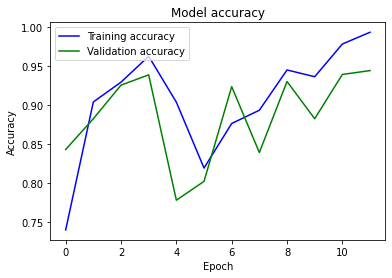

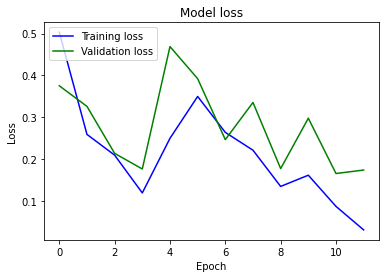

In [9]:

#Execution-3

# main function.

def main():
    Training_Validating('/content/drive/MyDrive/Project_Fake_News_Detection_DL/05_dataset/fake_news_dataset',130000,400,100,12,64,'x_test_3','y_test_3','history_3','model_3')
    Testing('x_test_3','y_test_3','history_3','model_3')
#############################################

# utility function of main.
if __name__ == '__main__':
    main()